In [101]:
import pandas as pd
import numpy as np
#import graphlab as tc
import turicreate as tc
from tqdm.notebook import tqdm
import turicreate.aggregate as agg
from sklearn.model_selection import train_test_split
from numpy.random import default_rng

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import pickle
import matplotlib.pyplot as plt

In [2]:
def f_create_network(data, gamma):
    apks = data['apk'].unique()
    k = apks.shape[0]
    sim_recom = tc.item_similarity_recommender.create(data, 
                                                      user_id='function', 
                                                      item_id='apk', 
                                                      similarity_type='jaccard', 
                                                      only_top_k=k, verbose=False)
    itms = sim_recom.get_similar_items(apks, k=k)
    # missing more "distant nodes", "not aggregating nodes"
    gw=itms[itms['score']>=1-gamma].groupby(key_column_names='apk', operations={'sims': agg.DISTINCT('similar')})
    
    

    
    ws = set(gw['apk'])
    net = dict()
    already_added = set()
    while len(ws)>0:
        w= ws.pop()

        simp = set(gw[gw['apk']==w]['sims'][0])
        simp = simp - already_added

        net[w] = list(simp)
        already_added.update(simp)
        already_added.add(w)

        ws = ws - simp
    
        
    # add solitary nodes & not-aggregating nodes
    if len(already_added)> 0:
        nds = apks.filter_by(list(already_added), exclude=True)
    else:
        nds = apks
        
    for n in nds:
        net[n] = []
        
    return net

In [2]:
mw = tc.load_sframe('../binarydata/funcs-encoded')
mw = mw.remove_column('fcount', inplace=True)

In [3]:
test_apns = np.load('../res/test-tc-1000.npy')

In [4]:
import pickle

net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [5]:
ref, mer = nets[0.0]

In [7]:
dds = mw.filter_by(values=ref.keys(), column_name='apk')

tts = mw.filter_by(values=test_apns, column_name='apk')

In [8]:
k = 1000
sim_recom = tc.item_similarity_recommender.create(
    dds, 
    user_id='function', 
    item_id='apk', 
    similarity_type='jaccard', 
    only_top_k=k, verbose=False)

In [9]:
itms = sim_recom.get_similar_items(tts['apk'].unique(), k=1)
itms

apk,similar,score,rank
2464,15622,1.0,1
19279,165,0.9996873736381531,1
18741,6558,0.9991733431816101,1
22823,16749,0.8333333134651184,1
4898,6048,0.3698123097419739,1
187,13364,0.9953552484512329,1
8024,23143,0.7093675136566162,1
13381,7372,0.47287702560424805,1
7572,84,0.8571428656578064,1
17985,3719,1.0,1


In [10]:
def get_distance(a1, a2):
    n = set(tts[tts['apk']==a1]['function'])
    m = set(dds[dds['apk']==a2]['function'])
    return len(n & m)/len(n|m)

In [11]:
get_distance(13381,7372)

0.47287704259308866

In [13]:
sit = itms.head(30)

In [14]:
sit

apk,similar,score,rank
2464,15622,1.0,1
19279,165,0.9996873736381531,1
18741,6558,0.9991733431816101,1
22823,16749,0.8333333134651184,1
4898,6048,0.3698123097419739,1
187,13364,0.9953552484512329,1
8024,23143,0.7093675136566162,1
13381,7372,0.47287702560424805,1
7572,84,0.8571428656578064,1
17985,3719,1.0,1


In [17]:
sit.apply(lambda r: get_distance(r['apk'], r['similar']))

dtype: float
Rows: 30
[1.0, 0.9996873534469283, 0.9991733259851199, 0.8333333333333334, 0.36981228451027964, 0.9953552382590745, 0.7093674939951962, 0.47287704259308866, 0.8571428571428571, 1.0, 0.3731437598736177, 0.9809843400447428, 0.9065497849818062, 0.4, 0.9978843441466855, 0.9997558891736849, 0.22393601828049128, 0.6141291676381441, 0.8607495413645496, 0.8392632241813602, 0.9934112381899552, 1.0, 0.9999234361840594, 0.2270011947431302, 0.6923076923076923, 1.0, 1.0, 0.9090909090909091, 0.5, 0.9999234361840594]

In [20]:
2464 in ref.keys(), ddn[dds]

True

In [21]:
15622 in ref.keys()

True

In [23]:
tts[0]['apk']

4227

In [25]:
itms = sim_recom.get_similar_items([tts[0]['apk']], k=1)

In [26]:
itms

apk,similar,score,rank
4227,9354,1.0,1


In [34]:
4227 in ref, 9354 in test_apns, 4227 in test_apns

(True, False, True)

In [36]:
overlap = [t for t in test_apns if t in ref]
    

In [38]:
len(overlap), len(test_apns)

(393, 1000)

In [2]:
# Issues with spliting

In [2]:
mw = tc.load_sframe('../binarydata/funcs-encoded')
mw.remove_column('fcount', inplace=True)
#subsamp = get_sample(mw=mw, frac=0.2)

napks = mw['apk'].unique().to_numpy()
#np.save(f"../res/test-tc-{test_size}", test)

In [4]:
test_size = 1000
train, test = train_test_split(napks, test_size=test_size, random_state=42)


In [5]:
def partition_ndframe(nd, n_parts):
    rn = default_rng(42)
    permuted_indices = rn.permutation(len(nd))

    dfs = []
    for i in range(n_parts):
        dfs.append(nd[permuted_indices[i::n_parts]])
    return dfs

In [9]:
parts = partition_ndframe(nd=train, n_parts=4)
sparts = [mw.filter_by(values=part, column_name='apk') for part in parts]

In [10]:
for i, p in enumerate(parts):
    a = [m for m in test if m in p]
    print(i, len(a))

0 0
1 0
2 0
3 0


In [2]:
test_apns = np.load('../res/test-tc-1000.npy')

In [3]:
import pickle

net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [12]:
mw = tc.load_sframe('../binarydata/funcs-encoded')
mw = mw.remove_column('fcount', inplace=True)

In [6]:
gamma = 0.6666666666666666
ref, mer = nets[gamma]

In [13]:
dds = mw.filter_by(values=ref.keys(), column_name='apk')
tts = mw.filter_by(values=test_apns, column_name='apk')

In [18]:
k = 1000
sim_recom = tc.item_similarity_recommender.create(
    dds, 
    user_id='function', 
    item_id='apk', 
    similarity_type='jaccard', 
    only_top_k=k, verbose=False)

In [26]:
sim_recom.recommend(users=test_apns[:10], new_user_data=tts, exclude_known=True, verbose=False)

function,apk,score,rank
3692,22591,0.19857606291770935,1
3692,2,0.1956120729446411,2
3692,9044,0.18745014071464539,3
3692,20103,0.1872456669807434,4
3692,20485,0.18647989630699158,5
3692,14367,0.1785830557346344,6
3692,15440,0.17461144924163818,7
3692,2111,0.17111042141914368,8
3692,17843,0.170549213886261,9
3692,4099,0.1702767312526703,10


In [27]:
#import turicreate as tc
#>>> sf = tc.SFrame('https://static.turi.com/datasets/audioscrobbler')
#train, test = tc.recommender.util.random_split_by_user(sf)
#m = tc.recommender.create(dds, user_id='function', item_id='apk')
#m.evaluate(test)

In [29]:
sim_recom.recommend?

In [30]:
## recommender for all exclude test from similar items?

In [78]:
def tc_based_nn(net, apks, data):
    anch = list(net.keys())
    anch.extend(apks)
    allt = data.filter_by(values=anch, column_name='apk')

    m = len(anch)
    sim_recom = tc.item_similarity_recommender.create(
        allt, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        only_top_k=m, verbose=False)
    
    # smaller k could be an optimization here
    items =sim_recom.get_similar_items(apks, k=m)
    # recomendations excluding network anchors 
    fitems = items.filter_by(values=apks, column_name='similar', exclude=True)
    
    return fitems.groupby(key_column_names=['apk'], operations={'nn': tc.aggregate.ARGMAX('score', 'similar')})

In [79]:
nns = tc_based_nn(ref, list(test_apns), mw)

In [81]:
nns.head()

apk,nn
26561,3
16257,20486
12088,3
2464,9218
26001,3
19279,11
18741,18454
18939,2074
21368,3
11452,20486


In [82]:
# convert to votes

In [89]:
def s_conver_to_probs(v):
    return 1.0 - v[1]/(v[0]+v[1])

probs = [s_conver_to_probs(ref[row['nn']]) for row in nns]

In [100]:
labels = pd.read_csv('../data/labels_encoded.csv', index_col=0)
true_values = [not labels.loc[a['apk']]['malware_label'] for a in nns]

In [102]:


#prc = dict()
#for gamma, probs in refs.items():
prc = precision_recall_curve(true_values, probs)

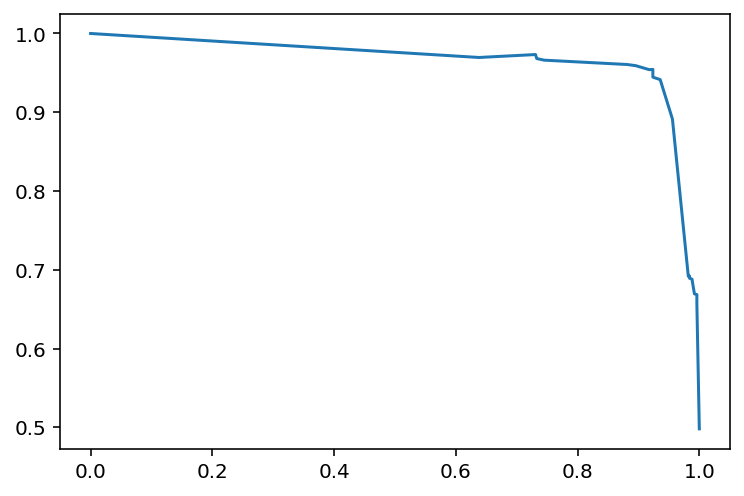

In [104]:
[precisons, recalls, thresholds] = prc
plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f}");